In [1]:
import random

import gymnasium as gym  # 原仓库基于pip install gym==0.18.3。现在统一升级为gymnasium
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [3]:
class Qnet(torch.nn.Module):  
    ''' 只有一层隐藏层的Q网络，用来估计动作价值函数 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [ ]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络,维持比较老的Qnet参数，每隔一段时间与Qnet同步
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state, eval=False):  # epsilon-贪婪策略采取动作
        if not eval and np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)  # 不包含上界
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)  # 指定数据类型，否则numpy的float64与pytorch的float32不匹配
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)    # view把数据分成n行1列，每一行对应一个action
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # 收集actions中的每个action,在q_net的输出中对应的Q值（即Qnet的输出是每个action的价值函数）
        
        # 使用target_q_net计算下个状态的最大Q值，用于计算TD target
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)   # max(1)表示在第1维取最大值；这个max()函数返回两个值，第一个是最大值，第二个是最大值的索引，使用[0]取最大值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        # dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        dqn_loss = F.mse_loss(q_values, q_targets)  # 上面的torch.mean()多余了，pytorch的mse_loss默认会对batch求均值
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [5]:
# 修改reward函数使carpole处在-1， 1之间
# 满足条件则reward + 0.1, 否则不加

class RewardFromObs(gym.Wrapper):
    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)  # 保存初始 state
        self.prev_state = state
        return state, info
    
    def step(self, action):
        # obs, _, done, info = self.env.step(action)  # 忽略原始 reward
        next_state, reward, terminated, truncated, info = self.env.step(action)
        # 根据 observation 自定义 reward
        if -1 <= next_state[0] <= 1:
            reward += 0.2
        reward -= abs(next_state[0] - self.prev_state[0]) * 0.1
        
        self.prev_state = next_state
        return next_state, reward, terminated, truncated, info

In [6]:
lr = 1e-4
num_episodes = 20000
hidden_dim = 64
gamma = 0.98
epsilon = 0.01   # 探索概率 1%
target_update = 10
buffer_size = 10000  
minimal_size = 500  # replay_buffer中最少存满这么多数据,才开始训练Q网络
batch_size = 128   # 每次从replaybuffer中sample的数量
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
# apply custom reward function
env = RewardFromObs(env)

random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n  # 离散动作空间
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []  # 记录每一个episode的return
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 再定义一个下标
            episode_return = 0
            # state = env.reset()
            state, info = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                # next_state, reward, done, _ = env.step(action)  # 原gym版本的step函数
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)  # 更新Q网络
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({  # 用来额外显示训练信息
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)  # 手动更新进度条

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 764.86it/s, episode=50,
# return=9.300]
# Iteration 1: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s, episode=100,
# return=12.300]
# Iteration 2: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, episode=150,
# return=123.000]
# Iteration 3: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it, episode=200,
# return=153.600]
# Iteration 4: 100%|██████████| 50/50 [01:30<00:00,  1.80s/it, episode=250,
# return=180.500]
# Iteration 5: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it, episode=300,
# return=185.000]
# Iteration 6: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, episode=350,
# return=193.900]
# Iteration 7: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=400,
# return=196.600]
# Iteration 8: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, episode=450,
# return=193.800]
# Iteration 9: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, episode=500,
# return=200.000]

/home/ruofei/miniforge3/envs/torchrl/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Iteration 0:   0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1515087/268879587.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)  # 指定数据类型，否则numpy的float64与pytorch的float32不匹配
Iteration 9: 100%|██████████| 2000/2000 [05:11<00:00,  6.42it/s, episode=20000, return=239.946]


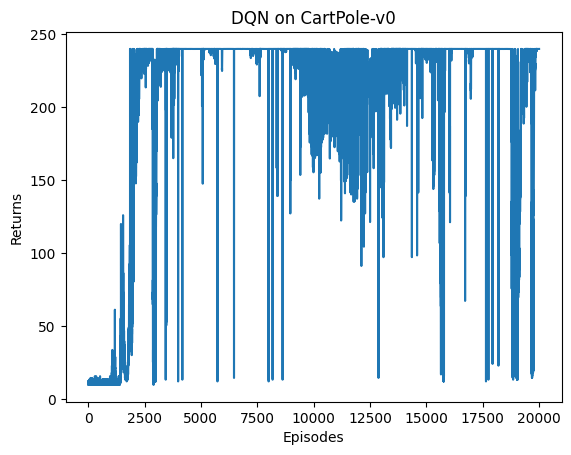

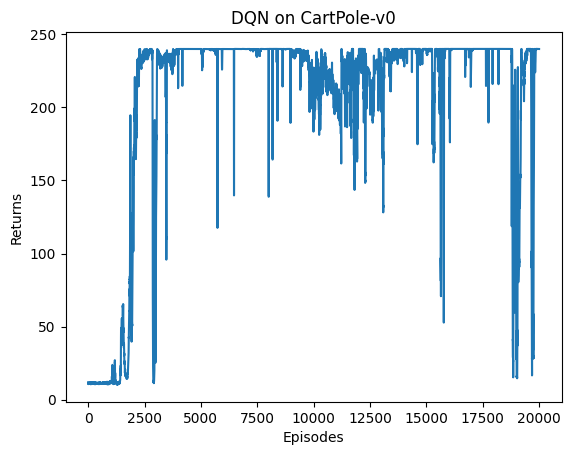

In [7]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [8]:
# 窗口可视化结果
env = gym.make("CartPole-v0", render_mode="human")  # human 模式会弹出窗口
env = RewardFromObs(env)

agent.q_net.eval()

with torch.no_grad():
    for i in range(10):
        state, info = env.reset()
        reward_sum = 0
        for j in tqdm(range(1000)):
            action = agent.take_action(state, eval=True)  # actor选择动作
            next_state, reward, terminated, truncated, info = env.step(action)
            reward_sum += reward
            env.render()
            if terminated or truncated:
                break
            state = next_state
        print(f"reward_sum {i}:", reward_sum)
env.close()

/home/ruofei/miniforge3/envs/torchrl/lib/python3.9/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
 20%|█▉        | 199/1000 [00:08<00:33, 23.97it/s]


reward_sum 0: 239.93954


 20%|█▉        | 199/1000 [00:08<00:33, 24.01it/s]


reward_sum 1: 239.93608


 20%|█▉        | 199/1000 [00:08<00:33, 23.95it/s]


reward_sum 2: 239.94206


 20%|█▉        | 199/1000 [00:08<00:33, 23.88it/s]


reward_sum 3: 239.93462


 20%|█▉        | 199/1000 [00:08<00:33, 24.00it/s]


reward_sum 4: 239.94414


 20%|█▉        | 199/1000 [00:08<00:33, 23.77it/s]


reward_sum 5: 239.93727


 20%|█▉        | 199/1000 [00:08<00:33, 23.75it/s]


reward_sum 6: 239.9348


 20%|█▉        | 199/1000 [00:08<00:33, 23.84it/s]


reward_sum 7: 239.9445


 20%|█▉        | 199/1000 [00:08<00:33, 23.97it/s]


reward_sum 8: 239.94882


 20%|█▉        | 199/1000 [00:08<00:33, 23.91it/s]

reward_sum 9: 239.94922


In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)  # in_channels和out_channels分别表示输入和输出的通道数
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255  # normalize到0-1之间
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.shape[0], -1)))
        return self.head(x)